# CSE5CV Assignment 2

Use this notebook to complete the coding portion of the assignment. Once you have finished, you can submit your code by downloading the notebook as a .ipynb file (File > Download > Download .ipynb) and submitting that file on LMS.

In [ ]:
# Type your student ID number as an integer here.
# e.g. STUDENT_ID = 22222222
STUDENT_ID = 22021468

**Before you continue**

Running a CNN on video data can be quite slow, so it is a good idea to make use of Google Colab's GPU acceleration to speed things up. To enable this, click Runtime > Change runtime type and select "GPU" as the Hardware accelerator.

Run the cell below to import modules that you are likely to need when completing the assignment.

In [1]:
import copy
import math

import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import torch
import torchvision
import torchvision.transforms.functional as tvtf

from google.colab import drive

The first thing that we need to do is connect Google Colab to your Google Drive. This allows you to:

* Upload a video file to your Google Drive and read it from this notebook.
* Save detections from this notebook to your Google Drive for later access so you don't need to run a detection model on your video multiple times.
* Write output files to your Google Drive from this notebook so that you can download them for submission.

Here is a step-by-step guide for you to follow:

1. In a new tab, go to https://drive.google.com/ and create a top-level folder for this assignment named `CSE5CV_Assignment`.
2. Double-click on `CSE5CV_Assignment` to open that folder.
3. Upload your video file (e.g. `task1.mkv`) into that folder. You can do this by dragging and dropping or using the "New" button.
4. Run the code cell below to connect your Google Drive with this notebook. You will need to grant permissions for this to work (follow the prompts).

In [2]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CSE5CV_Assignment

Mounted at /content/drive
/content/drive/MyDrive/CSE5CV_Assignment


Run the cell below to preview the first frame from your video. If your video is called something other than `task1.mkv` (e.g. `task1.mp4`), you will need to edit the first line.

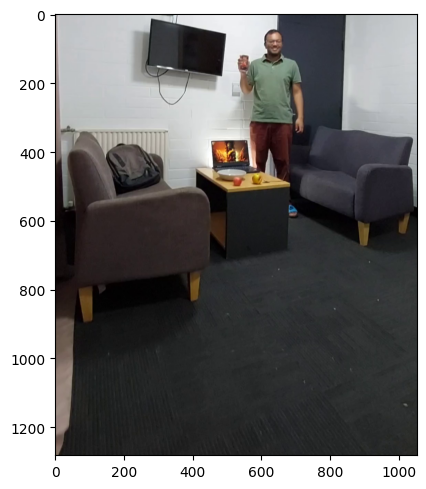

In [3]:
filename = './task1.mp4'

vid = cv2.VideoCapture(filename)
_, img = vid.read()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
ax.imshow(img)
fig.tight_layout()

Now that you have confirmed that your video is accessible and being read correctly, we can use Mask R-CNN to detect bounding boxes, object class labels, and confidence scores for each frame of the video.

The cell below will take a while to run, but the results will be saved to your Google Drive. This means that you should only ever have to run the cell below once, even if you close the notebook and come back to continue work at a later date. However, if you decide to re-record your video you will need to run the cell again to generate new detections.

In [ ]:
def preprocess_image(image):
    image = tvtf.to_tensor(image)
    image = image.unsqueeze(dim=0)
    return image

maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
maskrcnn.eval()
if torch.cuda.is_available():
    maskrcnn.cuda()

# Go to the start of the video
vid.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Record how long the video is (in frames)
vid_length = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))

# For each frame, read it, give it to maskrcnn and record the detections
all_boxes = []
all_labels = []
all_scores = []
for i in range(vid_length):
    _, img = vid.read()
    if img is None:
        break
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with torch.no_grad():
        input_image = preprocess_image(img)
        if torch.cuda.is_available():
            input_image = input_image.cuda()
        result = maskrcnn(input_image)[0]

    all_boxes.append(result['boxes'].detach().cpu().numpy())
    all_labels.append(result['labels'].detach().cpu().numpy())
    all_scores.append(result['scores'].detach().cpu().numpy())
    if i % 20 == 0:
        print(f'{i+1:0d}/{vid_length}')

torch.save(all_boxes, 'all_boxes.pt')
torch.save(all_labels, 'all_labels.pt')
torch.save(all_scores, 'all_scores.pt')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 78.6MB/s]


1/476
21/476
41/476
61/476
81/476
101/476
121/476
141/476
161/476
181/476
201/476
221/476
241/476
261/476
281/476
301/476
321/476
341/476
361/476
381/476
401/476
421/476
441/476
461/476


Now if you go to the `CSE5CV_Assignment` folder on Google Drive you should see three new files where the detections have been stored: `all_boxes.pt`, `all_labels.pt`, and `all_scores.pt`.

Let's load these detections from Google Drive now:

In [4]:
all_boxes = torch.load('all_boxes.pt')
all_labels = torch.load('all_labels.pt')
all_scores = torch.load('all_scores.pt')

vid_length = len(all_boxes)

print(f'Loaded detections for {vid_length} video frames')

<ipython-input-4-6aa52058e509>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_boxes = torch.load('all_boxes.pt')
<ipython-input-4-6aa52058e509>:2: FutureWarning: You a

Loaded detections for 476 video frames


Now it's your turn to complete the remaining tasks of the assignment by adding code in code cells below. You will find the "Pedestrian Tracking" lab coding notebook to be a useful reference for completing the assignment.

_You can create additional code cells by clicking the "+ Code" button in the toolbar._

In [15]:

#Task 2

# Gets detections for a frame only
def filter_frame_detections(boxes, labels, scores, allowed_classes, \
                            threshold=0.5):

    filtered_boxes = []
    filtered_labels = []
    filtered_scores = []

    for index in range(len(boxes)):
        label = labels[index]
        score = scores[index]
        if label in allowed_classes and score >= threshold:
            filtered_boxes.append(boxes[index])
            filtered_labels.append(label)
            filtered_scores.append(score)

    return filtered_boxes, filtered_labels, filtered_scores

# Gets detections from all frames
def filter_all_frames_detections(all_boxes, all_labels, all_scores, \
                                 allowed_classes, vid_length, threshold=0.5):

    filtered_boxes, filtered_labels, filtered_scores = [], [], []

    for frame_index in range(vid_length):
        filtered_box, filtered_label, filtered_score = \
        filter_frame_detections(all_boxes[frame_index], \
                                all_labels[frame_index], \
                                all_scores[frame_index], \
                                allowed_classes, threshold)
        filtered_boxes.append(filtered_box)
        filtered_labels.append(filtered_label)
        filtered_scores.append(filtered_score)

    return filtered_boxes, filtered_labels, filtered_scores

# Saves the collected detections into files
def save_filtered_detections(filtered_boxes, filtered_labels, filtered_scores):

    torch.save(filtered_boxes, 'filtered_boxes.pt')
    torch.save(filtered_labels, 'filtered_labels.pt')
    torch.save(filtered_scores, 'filtered_scores.pt')


allowed_classes = [1, 53, 50, 72, 27, 63, 51, 73, 77, 71]


filtered_bounding_boxes, filtered_labels, filtered_scores = \
filter_all_frames_detections(all_boxes, all_labels, all_scores, \
                             allowed_classes, vid_length, threshold=0.5)


save_filtered_detections(filtered_bounding_boxes, filtered_labels,\
                         filtered_scores)


In [17]:

# Task 3

# Distance between objects of the same class are calculated to distinguish
# between them
# Same object in different frames couldn't have traveled very far

def get_box_center(first_bounding_box):

    x_minimum, y_minimum, x_maximum, y_maximum = first_bounding_box
    center_of_x = (x_minimum + x_maximum) / 2
    center_of_y = (y_minimum + y_maximum) / 2
    return np.array([center_of_x, center_of_y])

def calculate_center_distance(first_bounding_box, second_bounding_box):

    first_center = get_box_center(first_bounding_box)
    second_center = get_box_center(second_bounding_box)
    return np.linalg.norm(first_center - second_center)

def track_objects(filtered_bounding_boxes, filtered_labels,\
                  maximum_distance=50):

    tracks = []

    for index, first_bounding_box in enumerate(filtered_bounding_boxes[0]):
        tracks.append({
            'label': filtered_labels[0][index],
            'bounding_box': [first_bounding_box],
            'track_id': index
        })

    for frame_index in range(1, len(filtered_bounding_boxes)):
        current_bounding_boxes = filtered_bounding_boxes[frame_index]
        current_labels = filtered_labels[frame_index]

        for index, second_bounding_box in enumerate(current_bounding_boxes):
            minimum_distance = float('inf')
            best_track = None

            for track in tracks:
                if track['label'] == current_labels[index]:
                    last_bounding_box = track['bounding_box'][-1]
                    distance = calculate_center_distance(last_bounding_box,\
                                                         second_bounding_box)

                    if distance < minimum_distance \
                    and distance < maximum_distance:
                        minimum_distance = distance
                        best_track = track

            if best_track:
                best_track['bounding_box'].append(second_bounding_box)
            else:
                new_track = {
                    'label': current_labels[index],
                    'bounding_box': [second_bounding_box],
                    'track_id': len(tracks)
                }
                tracks.append(new_track)
    return tracks

def draw_tracking_results(frame, tracks, frame_index):

    for track in tracks:
        if len(track['bounding_box']) > frame_index:
            current_bounding_box = track['bounding_box'][frame_index]
            x_minimum, y_minimum, x_maximum, y_maximum = \
            map(int, current_bounding_box)

            color = (int(track['track_id'] * 123) % 255, \
                     int(track['track_id'] * 73) % 255, \
                     int(track['track_id'] * 91) % 255)

            cv2.rectangle(frame, (x_minimum, y_minimum),\
                          (x_maximum, y_maximum), color, 2)

            cv2.putText(frame, f"Class: {track['label']}",\
                        (x_minimum, y_minimum - 10),\
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return frame

def create_tracking_video(input_video_path, output_video_path, tracks):

    video = cv2.VideoCapture(input_video_path)
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(video.get(cv2.CAP_PROP_FPS))

    output_video = cv2.VideoWriter(output_video_path, \
                                   cv2.VideoWriter_fourcc(*'mp4v'),\
                                   frame_rate, (frame_width, frame_height))

    frame_index = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break

        frame_with_tracking = draw_tracking_results(frame, tracks, frame_index)

        output_video.write(frame_with_tracking)
        frame_index += 1

    video.release()
    output_video.release()


tracks = track_objects(filtered_bounding_boxes, filtered_labels, \
                       maximum_distance=50)
create_tracking_video('task1.mp4', 'task3.mp4', tracks)
